In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [1]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-01-09 14:24:10--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  1.24MB/s    in 0.2s    

2025-01-09 14:24:11 (1.24 MB/s) - ‘names.txt’ saved [228145/228145]



In [24]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [25]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [26]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [112]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 16]) torch.Size([182625])
torch.Size([22655, 16]) torch.Size([22655])
torch.Size([22866, 16]) torch.Size([22866])


In [114]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

................ --> y
...............y --> u
..............yu --> h
.............yuh --> e
............yuhe --> n
...........yuhen --> g
..........yuheng --> .
................ --> d
...............d --> i
..............di --> o
.............dio --> n
............dion --> d
...........diond --> r
..........diondr --> e
.........diondre --> .
................ --> x
...............x --> a
..............xa --> v
.............xav --> i
............xavi --> e


In [115]:


# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [68]:
e = torch.randn(4,8,10)
B,T,C = e.shape
n = 8
x = e.view(B, T//n, C*n)
x.shape

torch.Size([4, 1, 80])

In [106]:
torch.manual_seed(42);

In [122]:
#    original network
#n_embd = 10 # the dimensionality of the character embedding vectors
#n_hidden = 200 # the number of neurons in the hidden layer of the MLP
'''
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
'''
# hierarchical network

n_embd = 27 # the dimensionality of the character embedding vectors
n_hidden = 27*2 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


23058


In [125]:
for layer in model.layers:
    print(layer.__class__.__name__,":", tuple(layer.out.shape))

Embedding : (32, 16, 27)
FlattenConsecutive : (32, 8, 54)
Linear : (32, 8, 54)
BatchNorm1d : (32, 8, 54)
Tanh : (32, 8, 54)
FlattenConsecutive : (32, 4, 108)
Linear : (32, 4, 54)
BatchNorm1d : (32, 4, 54)
Tanh : (32, 4, 54)
FlattenConsecutive : (32, 2, 108)
Linear : (32, 2, 54)
BatchNorm1d : (32, 2, 54)
Tanh : (32, 2, 54)
FlattenConsecutive : (32, 108)
Linear : (32, 54)
BatchNorm1d : (32, 54)
Tanh : (32, 54)
Linear : (32, 27)


In [126]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  

      0/ 200000: 3.2629
  10000/ 200000: 2.1937
  20000/ 200000: 2.1424
  30000/ 200000: 2.1644
  40000/ 200000: 1.9221
  50000/ 200000: 1.8655
  60000/ 200000: 2.2458
  70000/ 200000: 2.1333
  80000/ 200000: 2.0109
  90000/ 200000: 2.4417
 100000/ 200000: 2.0939
 110000/ 200000: 2.2310
 120000/ 200000: 1.9462
 130000/ 200000: 2.0591
 140000/ 200000: 1.8143
 150000/ 200000: 1.7408
 160000/ 200000: 2.1521
 170000/ 200000: 1.8429
 180000/ 200000: 1.7229
 190000/ 200000: 1.8262


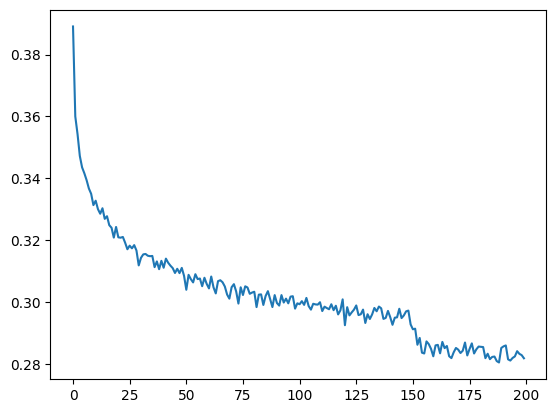

In [127]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [128]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [129]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.905363917350769
val 2.0299243927001953


In [130]:
for _ in range(20):
    out =  []
    context = [0] * block_size
    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print("".join(itos[i] for i in out))



jourde.
balene.
cartalia.
amadya.
camarie.
ninad.
leica.
marley.
qabry.
aylayah.
geonan.
ruy.
caydyn.
ally.
mallin.
loni.
danan.
kelyn.
durel.
brighd.


In [131]:
# We are missing an experimental harness on which we can run a number of experiments which allows us to tune the architecture very well

In [132]:
# Dilated convolution in neural network paper
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [133]:
logits = torch.zeros(8,27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])

logits.shape

torch.Size([8, 27])

In [ ]:
# With convolutions we can think of it as a for loop applying a linear filter over space of some input sequence
# its as if we takea structure and slide over it  e.g. a single name in the sequence
# It will also allow it to reuse a hidden layer instead of having to recalculate it 